## This Note Loads the dataset and does the augmentations on RAM (on memory) unlike the other ones.

---

# PART 1: IMPORT LIBRARIES AND MOUNT GOOGLE DRIVE

In [1]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

import albumentations as A

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

2025-11-01 16:47:55.307655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762015675.501524      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762015675.556733      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


`tqdm` is used to show **progress bars** during loops, it also gives you **estimated time** for the completion of the process you're carrying out.

It's used when:
* Finding minimum frames (PART 4) - Shows progress while scanning all videos
* Loading videos (PART 6) - Shows progress while loading non-shoplifter and shoplifter videos
* Applying augmentation (PART 10) - Shows progress while augmenting the training data

In [2]:
# os does not have a __version__ attribute
print(f"numpy version: {np.__version__}")
print(f"cv2 version: {cv2.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
# random does not have a __version__ attribute
# tqdm does not have a __version__ attribute
print(f"tensorflow version: {tf.__version__}")
import tensorflow_hub as hub   # didn't use it here, was for i3d model
print(f"tensorflow_hub version: {hub.__version__}")
# keras is part of tensorflow, use tensorflow version
import sklearn
print(f"sklearn version: {sklearn.__version__}")
print(f"albumentations version: {A.__version__}")

numpy version: 1.26.4
cv2 version: 4.12.0
matplotlib version: 3.7.2
seaborn version: 0.12.2
tensorflow version: 2.18.0
tensorflow_hub version: 0.16.1
sklearn version: 1.2.2
albumentations version: 2.0.8


In [3]:
import sys
import platform

print("=" * 60)
print("SYSTEM & LIBRARY VERSIONS")
print("=" * 60)

# Python and System Info
print(f"\nPython Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.machine()}")

print("\n" + "-" * 60)
print("CORE LIBRARIES")
print("-" * 60)

# Core libraries
import numpy as np
import cv2
import matplotlib
import seaborn as sns
import pandas as pd

print(f"NumPy: {np.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Pandas: {pd.__version__}")

print("\n" + "-" * 60)
print("DEEP LEARNING FRAMEWORKS")
print("-" * 60)

import tensorflow as tf
from tensorflow import keras

print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")

print("\n" + "-" * 60)
print("MACHINE LEARNING & METRICS")
print("-" * 60)

import sklearn
from scipy import __version__ as scipy_version

print(f"Scikit-learn: {sklearn.__version__}")
print(f"SciPy: {scipy_version}")

print("\n" + "-" * 60)
print("AUGMENTATION & UTILITIES")
print("-" * 60)

import albumentations as A

print(f"Albumentations: {A.__version__}")


print("\n" + "=" * 60)
print("VERSION CHECK COMPLETE ✓")
print("=" * 60)

SYSTEM & LIBRARY VERSIONS

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.56+-x86_64-with-glibc2.35
Architecture: x86_64

------------------------------------------------------------
CORE LIBRARIES
------------------------------------------------------------
NumPy: 1.26.4
OpenCV: 4.12.0
Matplotlib: 3.7.2
Seaborn: 0.12.2
Pandas: 2.2.3

------------------------------------------------------------
DEEP LEARNING FRAMEWORKS
------------------------------------------------------------
TensorFlow: 2.18.0
Keras: 3.8.0

------------------------------------------------------------
MACHINE LEARNING & METRICS
------------------------------------------------------------
Scikit-learn: 1.2.2
SciPy: 1.15.3

------------------------------------------------------------
AUGMENTATION & UTILITIES
------------------------------------------------------------
Albumentations: 2.0.8

VERSION CHECK COMPLETE ✓


In [4]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

___

# PART 2: EXTRACT ZIP FILE AND SET PATHS

In [5]:
# ZIP_PATH = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 6: Shop Lifting Detection models from scratch/Shop DataSet.zip'
# EXTRACT_PATH = '/content/shop_data'

### Extract zip file from Google Drive

In [6]:
# def extract_zip_file(zip_path, extract_path):
#     if not os.path.exists(extract_path):
#         os.makedirs(extract_path)
#         print(f"Extracting {zip_path}...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         print("Extraction complete!")
#     else:
#         print("Data already extracted!")

#     # List contents (top level only, break will stop after top level search)
#     for root, dirs, files in os.walk(extract_path):
#         print(f"\nDirectory: {root}")
#         print(f"Subdirectories: {dirs}")
#         print(f"Files count: {len(files)}")
#         break

In [7]:
# extract_zip_file(ZIP_PATH, EXTRACT_PATH)

### DEBUG: Find actual folder structure

In [8]:
# import os
# print(os.listdir("/kaggle/input"))

In [9]:
# print("Exploring extracted contents...")
# for root, dirs, files in os.walk(EXTRACT_PATH):
#     level = root.replace(EXTRACT_PATH, '').count(os.sep)
#     indent = ' ' * 2 * level
#     print(f'{indent}{os.path.basename(root)}/')
#     subindent = ' ' * 2 * (level + 1)
#     for file in files[:5]:  # Show first 5 files
#         print(f'{subindent}{file}')
#     if len(files) > 5:
#         print(f'{subindent}... and {len(files)-5} more files')

### Set dataset paths

In [10]:
## Kaggle

DATASET_PATH = '/kaggle/input/shop-lifting-dataset/Shop DataSet'
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, 'non shop lifters')
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, 'shop lifters')

---

# PART 3: CONFIGURATION AND HYPERPARAMETERS

In [11]:
## Video processing parameters
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
IMG_HEIGHT = 72 # 64
IMG_WIDTH = 72  # 64

NUM_FRAMES = 45  # was 40 
# NUM_FRAMES = 75  # Number of frames to extract from each video (from the min frames function)

CHANNELS = 3

In [12]:
## Training parameters
BATCH_SIZE = 3

# EPOCHS = 100
EPOCHS = 80

LEARNING_RATE = 0.0001

In [13]:
## Class labels, Multi-classification
CLASS_NAMES = ['non_shoplifter', 'shoplifter']
NUM_CLASSES = len(CLASS_NAMES)

In [14]:
# NUM_CLASSES = 1  # Binary classification (non-shoplifter or shoplifter)

In [15]:
print("Configuration set: \n")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Frames per video: {NUM_FRAMES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {CLASS_NAMES}")

Configuration set: 

Image size: 72x72
Frames per video: 45
Batch size: 3
Classes: ['non_shoplifter', 'shoplifter']


___

# PART 4: FIND MINIMUM FRAMES IN DATASET

**Find the video with the fewest number of frames in the entire dataset**

In [16]:
def find_minimum_frames(non_shoplifters_path, shoplifters_path):
    min_frames = float('inf')
    min_video_path = None

    print("Scanning non-shoplifter videos...")
    non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
                            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(non_shoplifter_files):
        video_path = os.path.join(non_shoplifters_path, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        if total_frames > 0 and total_frames < min_frames:
            min_frames = total_frames
            min_video_path = video_path

    print("Scanning shoplifter videos...")
    shoplifter_files = [f for f in os.listdir(shoplifters_path)
                        if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(shoplifter_files):
        video_path = os.path.join(shoplifters_path, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        if total_frames > 0 and total_frames < min_frames:
            min_frames = total_frames
            min_video_path = video_path

    print(f"\n{'='*60}")
    print(f"Minimum frames in dataset: {min_frames}")
    print(f"Video path: {min_video_path}")
    print('='*60)

    return min_frames, min_video_path

In [17]:
## Find minimum frames
min_frames, min_video_path = find_minimum_frames(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)

Scanning non-shoplifter videos...


100%|██████████| 531/531 [00:06<00:00, 88.12it/s]


Scanning shoplifter videos...


100%|██████████| 324/324 [00:04<00:00, 65.78it/s]


Minimum frames in dataset: 75
Video path: /kaggle/input/shop-lifting-dataset/Shop DataSet/non shop lifters/shop_lifter_n_215_1.mp4




---

# PART 5: Video Preprocessing Functions

### Extract fixed number of frames from video with temporal sampling

In [18]:
# def extract_frames_from_video(video_path, num_frames=NUM_FRAMES):
#     cap = cv2.VideoCapture(video_path)
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     if total_frames == 0:
#         cap.release()
#         return None

#     # Calculate frame indices to extract (evenly spaced)
#     frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

#     frames = []
#     for idx in frame_indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#         ret, frame = cap.read()
#         if ret:
#             # Resize and normalize
#             frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frames.append(frame)
#         else:
#             # If frame reading fails, use black frame
#             # frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))
#             print(f"Failed to read frame at index {idx} from video {video_path}")
#             break

#     cap.release()

#     # Ensure we have exactly num_frames
#     while len(frames) < num_frames:
#         frames.append(frames[-1] if frames else np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))

#     return np.array(frames[:num_frames])

In [19]:
def extract_frames_from_video(video_path, num_frames=NUM_FRAMES, jitter=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return None

    # Add random start index for temporal jitter
    if jitter and total_frames > num_frames:
        max_start = total_frames - num_frames
        start_idx = np.random.randint(0, max_start + 1)
    else:
        start_idx = 0

    # Evenly spaced indices with optional jitter start
    frame_indices = np.linspace(start_idx, start_idx + num_frames - 1, num_frames, dtype=int)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            print(f"Failed to read frame {idx} from {video_path}!!!")
            break

    cap.release()

    # Ensure correct length
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))

    return np.array(frames[:num_frames])

**Improved** `extract_frames_from_video()`

Adds random temporal offset so your model doesn’t see identical frame sequences every time.

**What’s new**:

* Randomized start point (start_idx) adds temporal variety.

* Still guarantees num_frames output (pads/truncates safely).

* Keeps motion information consistent and prevents identical sequences.

### Normalize Frames

In [20]:
def normalize_frames(frames):
    return frames.astype(np.float32) / 255.0

### Complete preprocessing pipeline for a single video

In [21]:
def preprocess_video(video_path):
    frames = extract_frames_from_video(video_path)
    if frames is None:
        return None
    frames = normalize_frames(frames)
    return frames

---

# Part 6: OPTIMIZED DUPLICATE DETECTION - BEFORE LOADING INTO MEMORY

This approach **detects and removes duplicate videos BEFORE loading them,
preventing data leakage and saving memory.**

**WORKFLOW:**
1. **Scan video files and extract lightweight features (32x32 frames)**
2. **Find duplicates and remove duplicate FILES from disk**
3. **THEN load remaining clean videos into memory**
4. **Apply augmentation only on clean data**
5. **Train model**

In [22]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

## STEP 1: LIGHTWEIGHT FUNCTIONS - Scan Without Full Loading

In [23]:
def get_video_paths_and_labels(non_shoplifters_path, shoplifters_path):
    """
    Get video paths and labels WITHOUT loading videos into memory
    Returns: video_paths (list), labels (list)
    """
    video_paths = []
    labels = []
    
    print("Scanning non-shoplifter videos...")
    non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
                            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    for video_file in non_shoplifter_files:
        video_path = os.path.join(non_shoplifters_path, video_file)
        video_paths.append(video_path)
        labels.append(0)  # non-shoplifter
    
    print(f"Scanning shoplifter videos...")
    shoplifter_files = [f for f in os.listdir(shoplifters_path)
                        if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    for video_file in shoplifter_files:
        video_path = os.path.join(shoplifters_path, video_file)
        video_paths.append(video_path)
        labels.append(1)  # shoplifter
    
    print(f"\n✅ Found {len(video_paths)} videos total")
    print(f"   Non-shoplifters: {sum(1 for l in labels if l == 0)}")
    print(f"   Shoplifters: {sum(1 for l in labels if l == 1)}")
    
    return np.array(video_paths), np.array(labels)

In [24]:
def extract_video_features(video_path, num_sample_frames=20):
    """
    Extract LIGHTWEIGHT features from a video (32x32 frames only)
    This doesn't load full-resolution videos into memory
    """
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            return None
        
        # Sample frames evenly throughout the video
        frame_indices = np.linspace(0, total_frames - 1, 
                                    min(num_sample_frames, total_frames), dtype=int)
        
        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Small 32x32 for similarity check only (very lightweight!)
                frame_small = cv2.resize(frame, (32, 32))
                frame_small = cv2.cvtColor(frame_small, cv2.COLOR_BGR2RGB)
                frame_small = frame_small.astype(np.float32) / 255.0
                frames.append(frame_small)
        
        cap.release()
        
        if len(frames) == 0:
            return None
        
        # Flatten into feature vector
        features = np.array(frames).flatten()
        return features
        
    except Exception as e:
        print(f"Error extracting features from {video_path}: {str(e)}")
        return None

In [25]:
def find_duplicate_videos(video_paths, labels, similarity_threshold=0.95, num_sample_frames=20):
    """
    Find duplicate videos using lightweight feature extraction
    """
    print("\n" + "="*60)
    print("DUPLICATE VIDEO DETECTION")
    print("="*60)
    print(f"Analyzing {len(video_paths)} videos...")
    print(f"Similarity threshold: {similarity_threshold:.2%}")
    
    # Extract features for all videos (lightweight!)
    features_list = []
    valid_indices = []
    
    for idx, video_path in enumerate(tqdm(video_paths, desc="Extracting features")):
        features = extract_video_features(video_path, num_sample_frames=num_sample_frames)
        if features is not None:
            features_list.append(features)
            valid_indices.append(idx)
        else:
            print(f"⚠️ Could not extract features from: {video_path}")
    
    # Convert to matrix
    feature_matrix = np.array(features_list)
    print(f"\n✅ Successfully extracted features from {len(valid_indices)}/{len(video_paths)} videos")
    print(f"Feature vector size: {feature_matrix.shape[1]}")
    
    # Compute pairwise cosine similarity
    print("\n🔍 Computing pairwise similarities...")
    similarity_matrix = cosine_similarity(feature_matrix)
    
    # Find duplicate pairs
    duplicate_pairs = []
    seen_pairs = set()
    
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            similarity = similarity_matrix[i, j]
            
            if similarity >= similarity_threshold:
                orig_i = valid_indices[i]
                orig_j = valid_indices[j]
                
                pair_key = tuple(sorted([orig_i, orig_j]))
                if pair_key not in seen_pairs:
                    seen_pairs.add(pair_key)
                    duplicate_pairs.append((orig_i, orig_j, similarity))
    
    # Sort by similarity (highest first)
    duplicate_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n🔍 Found {len(duplicate_pairs)} duplicate pairs with similarity ≥ {similarity_threshold:.2%}")
    
    return duplicate_pairs, feature_matrix

In [26]:
def analyze_duplicate_pairs(duplicate_pairs, video_paths, labels, top_n=20):
    """
    Analyze and display information about duplicate video pairs
    """
    if len(duplicate_pairs) == 0:
        print("\n✅ No duplicate videos found!")
        return None
    
    print("\n" + "="*60)
    print(f"TOP {min(top_n, len(duplicate_pairs))} DUPLICATE PAIRS")
    print("="*60)
    
    results_data = []
    
    for i, (idx1, idx2, similarity) in enumerate(duplicate_pairs[:top_n]):
        video1_path = video_paths[idx1]
        video2_path = video_paths[idx2]
        label1 = CLASS_NAMES[labels[idx1]]
        label2 = CLASS_NAMES[labels[idx2]]
        
        print(f"\n🔸 Pair #{i+1} - Similarity: {similarity:.4f} ({similarity*100:.2f}%)")
        print(f"   Video 1: {os.path.basename(video1_path)} (Label: {label1})")
        print(f"   Video 2: {os.path.basename(video2_path)} (Label: {label2})")
        
        same_label = "✅ Same class" if label1 == label2 else "⚠️ Different classes!"
        print(f"   {same_label}")
        
        results_data.append({
            'pair_id': i+1,
            'video1_idx': idx1,
            'video2_idx': idx2,
            'video1_name': os.path.basename(video1_path),
            'video2_name': os.path.basename(video2_path),
            'label1': label1,
            'label2': label2,
            'similarity': similarity,
            'same_label': label1 == label2
        })
    
    df_duplicates = pd.DataFrame(results_data)
    
    # Summary statistics
    print("\n" + "="*60)
    print("DUPLICATE STATISTICS")
    print("="*60)
    print(f"Total duplicate pairs: {len(duplicate_pairs)}")
    print(f"Same-class duplicates: {sum(labels[p[0]] == labels[p[1]] for p in duplicate_pairs)}")
    print(f"Cross-class duplicates: {sum(labels[p[0]] != labels[p[1]] for p in duplicate_pairs)}")
    print(f"Average similarity: {np.mean([p[2] for p in duplicate_pairs]):.4f}")
    print(f"Max similarity: {np.max([p[2] for p in duplicate_pairs]):.4f}")
    print(f"Min similarity: {np.min([p[2] for p in duplicate_pairs]):.4f}")
    
    return df_duplicates

In [27]:
def visualize_duplicate_pair(duplicate_pairs, video_paths, pair_index=0, num_frames_to_show=3):
    """
    Visualize a duplicate video pair side-by-side
    Uses your existing extract_frames_from_video function
    """
    if len(duplicate_pairs) == 0:
        print("No duplicate pairs to visualize")
        return
    
    idx1, idx2, similarity = duplicate_pairs[pair_index]
    video1_path = video_paths[idx1]
    video2_path = video_paths[idx2]
    
    print(f"\n📊 Visualizing Pair #{pair_index+1} (Similarity: {similarity:.4f})")
    
    # Load frames from both videos
    frames1 = extract_frames_from_video(video1_path, num_frames=num_frames_to_show, jitter=False)
    frames2 = extract_frames_from_video(video2_path, num_frames=num_frames_to_show, jitter=False)
    
    if frames1 is None or frames2 is None:
        print("Failed to load videos for visualization")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, num_frames_to_show, figsize=(15, 6))
    
    for i in range(num_frames_to_show):
        axes[0, i].imshow(frames1[i])
        axes[0, i].set_title(f'Video 1 - Frame {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(frames2[i])
        axes[1, i].set_title(f'Video 2 - Frame {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Duplicate Pair Comparison (Similarity: {similarity:.4f})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [28]:
def remove_duplicate_videos(duplicate_pairs, video_paths, labels, 
                           strategy='keep_first', dry_run=True):
    """
    PHYSICALLY DELETE duplicate video files from disk
    This should be run BEFORE loading videos into memory
    
    Args:
        duplicate_pairs: List of (idx1, idx2, similarity) tuples
        video_paths: Array of video paths
        labels: Array of labels
        strategy: Which video to keep ('keep_first', 'keep_random', 'keep_shortest')
        dry_run: If True, simulate only (don't delete)
    
    Returns:
        indices_to_remove: Indices of removed videos
        cleaned_video_paths: Paths after removal
        cleaned_labels: Labels after removal
    """
    print("\n" + "="*60)
    print("REMOVING DUPLICATE VIDEOS FROM DISK")
    print("="*60)
    print(f"Strategy: {strategy}")
    print(f"Dry run: {'Yes (simulation only)' if dry_run else 'No (WILL DELETE FILES!)'}")
    
    if len(duplicate_pairs) == 0:
        print("\n✅ No duplicates to remove!")
        return [], video_paths, labels
    
    indices_to_remove = set()
    
    for idx1, idx2, similarity in duplicate_pairs:
        if strategy == 'keep_first':
            remove_idx = idx2
        elif strategy == 'keep_random':
            remove_idx = random.choice([idx1, idx2])
        elif strategy == 'keep_shortest':
            cap1 = cv2.VideoCapture(video_paths[idx1])
            frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
            cap1.release()
            
            cap2 = cv2.VideoCapture(video_paths[idx2])
            frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
            cap2.release()
            
            remove_idx = idx1 if frames1 > frames2 else idx2
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        if idx1 not in indices_to_remove and idx2 not in indices_to_remove:
            indices_to_remove.add(remove_idx)
    
    indices_to_remove = sorted(list(indices_to_remove))
    
    print(f"\n📊 Videos to remove: {len(indices_to_remove)}")
    print(f"Videos to keep: {len(video_paths) - len(indices_to_remove)}")
    
    print("\n🗑️ Videos marked for removal:")
    for idx in indices_to_remove[:10]:
        print(f"   - {os.path.basename(video_paths[idx])} (Label: {CLASS_NAMES[labels[idx]]})")
    if len(indices_to_remove) > 10:
        print(f"   ... and {len(indices_to_remove) - 10} more")
    
    # PHYSICALLY DELETE FILES from disk
    if not dry_run:
        print("\n⚠️ DELETING FILES FROM DISK...")
        deleted_count = 0
        for idx in tqdm(indices_to_remove, desc="Deleting files"):
            video_path = video_paths[idx]
            try:
                if os.path.exists(video_path):
                    os.remove(video_path)
                    deleted_count += 1
                else:
                    print(f"⚠️ File not found: {os.path.basename(video_path)}")
            except Exception as e:
                print(f"❌ Failed to delete {video_path}: {str(e)}")
        print(f"✅ Successfully deleted {deleted_count} files from disk")
    else:
        print("\n✅ Dry run complete - no files were deleted")
    
    # Create cleaned arrays
    keep_mask = np.ones(len(video_paths), dtype=bool)
    keep_mask[indices_to_remove] = False
    
    cleaned_video_paths = video_paths[keep_mask]
    cleaned_labels = labels[keep_mask]
    
    if not dry_run:
        print(f"\n✅ Cleaning complete!")
        print(f"Original dataset: {len(video_paths)} videos")
        print(f"Cleaned dataset: {len(cleaned_video_paths)} videos")
        print(f"Removed: {len(indices_to_remove)} videos ({len(indices_to_remove)/len(video_paths)*100:.2f}%)")
    else:
        print(f"\n✅ Simulation complete!")
        print(f"Would remove: {len(indices_to_remove)} videos ({len(indices_to_remove)/len(video_paths)*100:.2f}%)")
    
    return indices_to_remove, cleaned_video_paths, cleaned_labels

## STEP 2: MODIFIED - Get indices to skip (instead of deleting)

In [29]:
# def get_videos_to_skip(duplicate_pairs, video_paths, labels, strategy='keep_first'):
#     """
#     Determine which video indices to SKIP when loading (Kaggle-compatible)
    
#     Args:
#         duplicate_pairs: List of (idx1, idx2, similarity) tuples
#         video_paths: Array of video paths
#         labels: Array of labels
#         strategy: Which video to keep ('keep_first', 'keep_random', 'keep_shortest')
    
#     Returns:
#         indices_to_skip: Set of indices to skip during loading
#         paths_to_skip: Set of file paths to skip
#     """
#     print("\n" + "="*60)
#     print("MARKING DUPLICATES TO SKIP (KAGGLE MODE)")
#     print("="*60)
#     print(f"Strategy: {strategy}")
#     print("Note: Files won't be deleted (Kaggle input is read-only)")
    
#     if len(duplicate_pairs) == 0:
#         print("\n✅ No duplicates to skip!")
#         return set(), set()
    
#     indices_to_skip = set()
    
#     for idx1, idx2, similarity in duplicate_pairs:
#         if strategy == 'keep_first':
#             skip_idx = idx2
#         elif strategy == 'keep_random':
#             skip_idx = random.choice([idx1, idx2])
#         elif strategy == 'keep_shortest':
#             cap1 = cv2.VideoCapture(video_paths[idx1])
#             frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
#             cap1.release()
            
#             cap2 = cv2.VideoCapture(video_paths[idx2])
#             frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
#             cap2.release()
            
#             skip_idx = idx1 if frames1 > frames2 else idx2
#         else:
#             raise ValueError(f"Unknown strategy: {strategy}")
        
#         if idx1 not in indices_to_skip and idx2 not in indices_to_skip:
#             indices_to_skip.add(skip_idx)
    
#     # Create set of paths to skip
#     paths_to_skip = {video_paths[idx] for idx in indices_to_skip}
    
#     print(f"\n📊 Videos to skip: {len(indices_to_skip)}")
#     print(f"Videos to load: {len(video_paths) - len(indices_to_skip)}")
    
#     print("\n🚫 Videos marked to skip:")
#     for idx in sorted(list(indices_to_skip))[:10]:
#         print(f"   - {os.path.basename(video_paths[idx])} (Label: {CLASS_NAMES[labels[idx]]})")
#     if len(indices_to_skip) > 10:
#         print(f"   ... and {len(indices_to_skip) - 10} more")
    
#     print(f"\n✅ Marked {len(indices_to_skip)} duplicates to skip during loading")
#     print(f"This prevents data leakage without modifying Kaggle input dataset")
    
#     return indices_to_skip, paths_to_skip

In [30]:
def skip_duplicate_videos(duplicate_pairs, video_paths, labels, strategy='keep_first'):
    """
    Skip one video from each duplicate pair (instead of deleting from disk)
    Used in Kaggle or read-only datasets.
    
    Args:
        duplicate_pairs: List of (idx1, idx2, similarity) tuples
        video_paths: Array of video paths
        labels: Array of labels
        strategy: Which video to keep ('keep_first', 'keep_random', 'keep_shortest')
    
    Returns:
        skipped_indices: Indices of skipped videos
        filtered_video_paths: Paths after skipping duplicates
        filtered_labels: Labels after skipping duplicates
    """
    print("\n" + "="*60)
    print("SKIPPING DUPLICATE VIDEOS (No deletion, safe for Kaggle)")
    print("="*60)
    print(f"Strategy: {strategy}")
    
    if len(duplicate_pairs) == 0:
        print("\n✅ No duplicates to skip!")
        return [], video_paths, labels
    
    indices_to_skip = set()
    
    for idx1, idx2, similarity in duplicate_pairs:
        if strategy == 'keep_first':
            skip_idx = idx2
        elif strategy == 'keep_random':
            skip_idx = random.choice([idx1, idx2])
        elif strategy == 'keep_shortest':
            cap1 = cv2.VideoCapture(video_paths[idx1])
            frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
            cap1.release()
            
            cap2 = cv2.VideoCapture(video_paths[idx2])
            frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
            cap2.release()
            
            skip_idx = idx1 if frames1 > frames2 else idx2
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        # Ensure we only skip one per pair and avoid double-skipping
        if idx1 not in indices_to_skip and idx2 not in indices_to_skip:
            indices_to_skip.add(skip_idx)
    
    indices_to_skip = sorted(list(indices_to_skip))
    
    print(f"\n📊 Videos to skip: {len(indices_to_skip)}")
    print(f"Videos to keep: {len(video_paths) - len(indices_to_skip)}")
    
    print("\n🗂️ Skipped videos (first 10 shown):")
    for idx in indices_to_skip[:10]:
        print(f"   - {os.path.basename(video_paths[idx])} (Label: {CLASS_NAMES[labels[idx]]})")
    if len(indices_to_skip) > 10:
        print(f"   ... and {len(indices_to_skip) - 10} more")
    
    # Create filtered arrays
    keep_mask = np.ones(len(video_paths), dtype=bool)
    keep_mask[indices_to_skip] = False
    
    filtered_video_paths = video_paths[keep_mask]
    filtered_labels = labels[keep_mask]
    
    print(f"\n✅ Skipping complete!")
    print(f"Original dataset: {len(video_paths)} videos")
    print(f"Cleaned dataset: {len(filtered_video_paths)} videos")
    print(f"Skipped: {len(indices_to_skip)} videos ({len(indices_to_skip)/len(video_paths)*100:.2f}%)")
    
    return indices_to_skip, filtered_video_paths, filtered_labels

## STEP 3: MODIFIED load_video_dataset - Skip duplicates during loading

In [31]:
def load_video_dataset_skip_duplicates(non_shoplifters_path, shoplifters_path, paths_to_skip=None):
    """
    MODIFIED: Load videos but SKIP duplicates
    
    Args:
        non_shoplifters_path: Path to non-shoplifter videos
        shoplifters_path: Path to shoplifter videos
        paths_to_skip: Set of file paths to skip (duplicates)
    
    Returns:
        videos: Array of video frames
        labels: Array of labels
    """
    if paths_to_skip is None:
        paths_to_skip = set()
    
    videos = []
    labels = []
    skipped_count = 0

    print("Loading non-shoplifter videos (skipping duplicates)...")
    non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
                            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(non_shoplifter_files):
        video_path = os.path.join(non_shoplifters_path, video_file)
        video_path = os.path.abspath(video_path)  # [✅for all the paths you want to collect]
        
        # ⭐ SKIP if this path is marked as duplicate
        if video_path in paths_to_skip:
            skipped_count += 1
            continue
        
        frames = preprocess_video(video_path)
        if frames is not None:
            videos.append(frames)
            labels.append(0)

    print(f"\nLoading shoplifter videos (skipping duplicates)...")
    shoplifter_files = [f for f in os.listdir(shoplifters_path)
                        if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(shoplifter_files):
        video_path = os.path.join(shoplifters_path, video_file)
        video_path = os.path.abspath(video_path)   # [✅for all the paths you want to collect]
        
        # ⭐ SKIP if this path is marked as duplicate
        if video_path in paths_to_skip:
            skipped_count += 1
            continue
        
        frames = preprocess_video(video_path)
        if frames is not None:
            videos.append(frames)
            labels.append(1)

    videos = np.array(videos)
    labels = np.array(labels)

    print("\nDataset loaded successfully!\n")
    print(f"Total videos loaded: {len(videos)}")
    print(f"Duplicates skipped: {skipped_count}")
    print(f"Non-shoplifters: {np.sum(labels == 0)}")
    print(f"Shoplifters: {np.sum(labels == 1)}")
    print(f"Video shape: {videos.shape}")

    return videos, labels

## STEP 4: COMPLETE PIPELINE - Use this in your notebook


KAGGLE DUPLICATE DETECTION PIPELINE
Scanning non-shoplifter videos...
Scanning shoplifter videos...

✅ Found 855 videos total
   Non-shoplifters: 531
   Shoplifters: 324

DUPLICATE VIDEO DETECTION
Analyzing 855 videos...
Similarity threshold: 100.00%


Extracting features: 100%|██████████| 855/855 [10:50<00:00,  1.31it/s]



✅ Successfully extracted features from 855/855 videos
Feature vector size: 76800

🔍 Computing pairwise similarities...

🔍 Found 91 duplicate pairs with similarity ≥ 100.00%

TOP 10 DUPLICATE PAIRS

🔸 Pair #1 - Similarity: 1.0000 (100.00%)
   Video 1: shop_lifter_n_155.mp4 (Label: non_shoplifter)
   Video 2: shop_lifter_n_155_1.mp4 (Label: non_shoplifter)
   ✅ Same class

🔸 Pair #2 - Similarity: 1.0000 (100.00%)
   Video 1: shop_lifter_n_136_1.mp4 (Label: non_shoplifter)
   Video 2: shop_lifter_n_136.mp4 (Label: non_shoplifter)
   ✅ Same class

🔸 Pair #3 - Similarity: 1.0000 (100.00%)
   Video 1: shop_lifter_n_135.mp4 (Label: non_shoplifter)
   Video 2: shop_lifter_n_135_1.mp4 (Label: non_shoplifter)
   ✅ Same class

🔸 Pair #4 - Similarity: 1.0000 (100.00%)
   Video 1: shop_lifter_n_186_1.mp4 (Label: non_shoplifter)
   Video 2: shop_lifter_n_186.mp4 (Label: non_shoplifter)
   ✅ Same class

🔸 Pair #5 - Similarity: 1.0000 (100.00%)
   Video 1: shop_lifter_n_139_1.mp4 (Label: non_shoplift

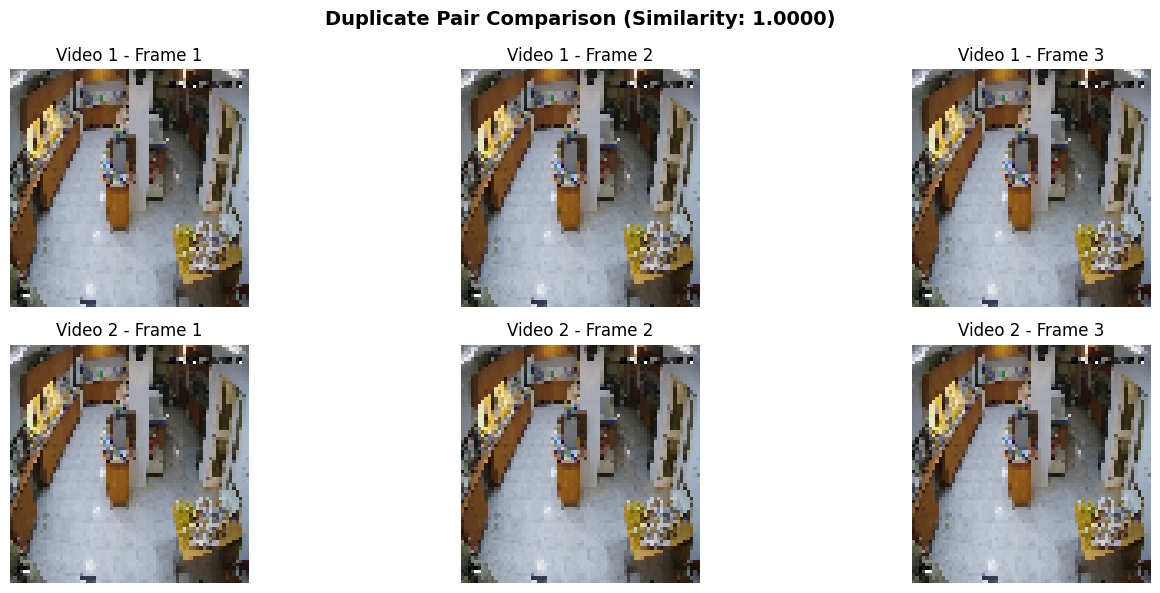


SKIPPING DUPLICATE VIDEOS (No deletion, safe for Kaggle)
Strategy: keep_first

📊 Videos to skip: 91
Videos to keep: 764

🗂️ Skipped videos (first 10 shown):
   - shop_lifter_n_123_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_130_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_107_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_154_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_49_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_29_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_180.mp4 (Label: non_shoplifter)
   - shop_lifter_n_82.mp4 (Label: non_shoplifter)
   - shop_lifter_n_2_1.mp4 (Label: non_shoplifter)
   - shop_lifter_n_56.mp4 (Label: non_shoplifter)
   ... and 81 more

✅ Skipping complete!
Original dataset: 855 videos
Cleaned dataset: 764 videos
Skipped: 91 videos (10.64%)

✅ Will skip 91 duplicate videos during loading

LOADING CLEAN DATASET INTO MEMORY
Loading non-shoplifter videos (skipping duplicates)...


100%|██████████| 531/531 [07:58<00:00,  1.11it/s]



Loading shoplifter videos (skipping duplicates)...


100%|██████████| 324/324 [11:17<00:00,  2.09s/it]



Dataset loaded successfully!

Total videos loaded: 764
Duplicates skipped: 91
Non-shoplifters: 440
Shoplifters: 324
Video shape: (764, 45, 72, 72, 3)


In [32]:
print("\n" + "="*60)
print("KAGGLE DUPLICATE DETECTION PIPELINE")
print("="*60)

# Step 1: Get all video paths
video_paths, labels = get_video_paths_and_labels(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)

# Step 2: Find duplicates
duplicate_pairs, feature_matrix = find_duplicate_videos(
    video_paths, 
    labels, 
    similarity_threshold=1,  # Adjust as needed (0.95 = 95% similarity)
    num_sample_frames=25
)

# Step 3: Analyze and visualize
paths_to_skip = set()  # Default: no skips

if len(duplicate_pairs) > 0:
    df_duplicates = analyze_duplicate_pairs(duplicate_pairs, video_paths, labels, top_n=10)
    
    # Visualize
    print("\n📊 Visualizing top duplicate pair...")
    visualize_duplicate_pair(duplicate_pairs, video_paths, pair_index=0, num_frames_to_show=3)
    
    # Get indices to skip
    indices_to_skip, cleaned_video_paths, cleaned_labels = skip_duplicate_videos(
        duplicate_pairs, 
        video_paths, 
        labels,
        strategy='keep_first'  # Options: 'keep_first', 'keep_random', 'keep_shortest'
    )

    ## Convert to paths for loader (pick absolute path [✅for all the paths you want to collect])
    paths_to_skip = set(os.path.abspath(video_paths[idx]) for idx in indices_to_skip)

    print("\n" + "="*60)
    print(f"✅ Will skip {len(paths_to_skip)} duplicate videos during loading")
    print("="*60)

else:
    print("\n✅ No duplicates found! Will load all videos.")

# Step 4: Load dataset (skipping duplicates)
print("\n" + "="*60)
print("LOADING CLEAN DATASET INTO MEMORY")
print("="*60)

videos, labels = load_video_dataset_skip_duplicates(
    NON_SHOPLIFTERS_PATH, 
    SHOPLIFTERS_PATH,
    paths_to_skip=paths_to_skip  # Pass skip list
)

* The progress bar only shows how many videos it checks, not how many it keeps.

* The 91 duplicates are being skipped exactly as intended.

In [33]:
print("\n✅ Clean dataset loaded into memory!")
print(f"Total videos: {len(videos)}")
print(f"No duplicates - safe for augmentation and training!")


✅ Clean dataset loaded into memory!
Total videos: 764
No duplicates - safe for augmentation and training!


### SUMMARY: What This Does

**KAGGLE-COMPATIBLE APPROACH**:
1. Scans all videos and finds duplicates
2. Creates a "skip list" of duplicate paths
3. Loads videos into memory, SKIPPING duplicates from the list
4. Only clean (non-duplicate) videos end up in memory
5. Augmentation and training use clean data only

**WORKFLOW**:
   Scan → Find duplicates → Create skip list → Load clean videos → Train

**KEY DIFFERENCES FROM DISK DELETION**:
   - Files remain on disk (Kaggle input is read-only)
   - Duplicates are skipped during loading (never enter memory)
   - Same result: clean dataset without data leakage
   - Works perfectly on Kaggle!

**MEMORY SAVINGS**:
   - Original: Load 855 videos (including 91 duplicates)
   - Optimized: Load 764 videos (duplicates never loaded)
   - Result: ~10% memory savings + no data leakage



---

# PART 7: LOAD All DATASET (not using part 6)

### Load all videos and their labels from both directories

In [34]:
# def load_video_dataset(non_shoplifters_path, shoplifters_path):
#     videos = []
#     labels = []

#     print("Loading non-shoplifter videos...")
#     non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
#                             if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

#     for video_file in tqdm(non_shoplifter_files):
#         video_path = os.path.join(non_shoplifters_path, video_file)
#         frames = preprocess_video(video_path)
#         if frames is not None:
#             videos.append(frames)
#             labels.append(0)  # 0 for non-shoplifter

#     print(f"\nLoading shoplifter videos...")
#     shoplifter_files = [f for f in os.listdir(shoplifters_path)
#                         if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

#     for video_file in tqdm(shoplifter_files):
#         video_path = os.path.join(shoplifters_path, video_file)
#         frames = preprocess_video(video_path)
#         if frames is not None:
#             videos.append(frames)
#             labels.append(1)  # 1 for shoplifter

#     videos = np.array(videos)
#     labels = np.array(labels)

#     print("\nDataset loaded successfully!\n")
#     print(f"Total videos: {len(videos)}")
#     print(f"Non-shoplifters: {np.sum(labels == 0)}")
#     print(f"Shoplifters: {np.sum(labels == 1)}")
#     print(f"Video shape: {videos.shape}")

#     return videos, labels

In [35]:
## Load the dataset
# videos, labels = load_video_dataset(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)

---

# PART 8: TRAIN-TEST SPLIT

### If I want to split the validation set After Augmentation in the fitting process

In [36]:
# # Split data into train and test sets (80-20 split)
# videos_train, videos_test, labels_train, labels_test = train_test_split(
#     videos, labels, test_size=0.2, random_state=42, stratify=labels
# )

# print(f"Training set: {videos_train.shape[0]} videos")
# print(f"Test set: {videos_test.shape[0]} videos")
# print(f"Training non-shoplifters: {np.sum(labels_train == 0)}")
# print(f"Training shoplifters: {np.sum(labels_train == 1)}")
# print(f"Test non-shoplifters: {np.sum(labels_test == 0)}")
# print(f"Test shoplifters: {np.sum(labels_test == 1)}")

### If I want to split the validation set before Augmentation (better for memory)

In [37]:
# Split data into train and temp (which will be split into val + test) (70-30) (60%-40% split - older code test_size=0.4)
videos_train, videos_temp, labels_train, labels_temp = train_test_split(
    videos, labels, test_size=0.3, random_state=42, stratify=labels
)

## Further split temp into test and validation (15%-15%) (20%-20% - older code)
videos_val, videos_test, labels_val, labels_test = train_test_split(
    videos_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
)

print("\n" + "="*60)
print("DATA SPLIT")
print("="*60)

print(f"Training set: {videos_train.shape[0]} videos")
print(f"Validation set: {videos_val.shape[0]} videos")
print(f"Test set: {videos_test.shape[0]} videos")

print(f"Training non-shoplifters: {np.sum(labels_train == 0)}")
print(f"Training shoplifters: {np.sum(labels_train == 1)}")

print(f"Validation non-shoplifters: {np.sum(labels_val == 0)}")
print(f"Validation shoplifters: {np.sum(labels_val == 1)}")

print(f"Test non-shoplifters: {np.sum(labels_test == 0)}")
print(f"Test shoplifters: {np.sum(labels_test == 1)}")


DATA SPLIT
Training set: 534 videos
Validation set: 115 videos
Test set: 115 videos
Training non-shoplifters: 308
Training shoplifters: 226
Validation non-shoplifters: 66
Validation shoplifters: 49
Test non-shoplifters: 66
Test shoplifters: 49


The `stratify=labels` parameter in the `train_test_split` function ensures that the split is performed in a way that maintains the same proportion of classes in both the training and testing sets as in the original dataset.

This is particularly important when dealing with imbalanced datasets, where one class is significantly more represented than others.

It helps to prevent the model from being biased towards the majority class.

---

# PART 9: AUGMENTATION FUNCTIONS - INDIVIDUAL PREVIEW

In [38]:
import albumentations as A

### Create Albumentations Pipeline

In [39]:
def get_augmentation_pipeline():
    """Create Albumentations pipeline for spatial augmentations"""
    return A.ReplayCompose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.4),
        # A.Rotate(limit=15, p=0.3),

        # Removed A.RandomScale - it changes image dimensions
        # Using ShiftScaleRotate instead which maintains size
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=0,  # Rotation already handled above
            border_mode=cv2.BORDER_CONSTANT,
            p=0.3
        ),
    ])

#### E:

`p=1.0` for individual Augmentation Technique Visualization

Uses `ReplayCompose` to apply same transformation to **all frames** in the video.

`ReplayCompose` in general is used when dealing with **videos**.

### Temporal crop - not in albumentations, manual implementation

In [40]:
# def augment_temporal_crop(frames, crop_ratio=0.95):
#     """
#     Temporal augmentation - crop and resample video
#     **GUARANTEES output has same length as input
#     """
#     num_frames = len(frames)
#     crop_length = max(1, int(num_frames * crop_ratio))  # Ensure at least 1 frame

#     if crop_length >= num_frames:
#         return frames  # No cropping needed

#     start_idx = np.random.randint(0, num_frames - crop_length + 1)
#     cropped = frames[start_idx:start_idx + crop_length]

#     # Resample back to original length
#     indices = np.linspace(0, len(cropped) - 1, num_frames, dtype=int)
#     return cropped[indices]

#### E:

**Why Use Temporal Crop?**

It helps your model learn that **the exact timing of actions isn't fixed**, only **their visual pattern** matters.

For example:

* A shoplifter might reach for an item at frame 10 in one video and frame 20 in another.

* Temporal cropping ensures your model doesn’t overfit to “where” in time the event occurs.

So it introduces **temporal invariance** — the model becomes robust to when something happens in the sequence.

Step-by-step:

1. Takes, say, 30 frames (num_frames = 30).

2. Randomly selects 80% of them (crop_length = 24).

3. Chooses a random starting point (e.g., frame 5).

4. Extracts frames [F5 … F28].

5. Then stretches or samples back to 30 frames for model consistency.

### Apply single Augmentation for Visualization

In [41]:
def apply_single_augmentation(frames, aug_name):
    """Apply single augmentation with p=1.0"""
    frames_uint8 = (frames * 255).astype(np.uint8)

    if aug_name == 'Horizontal Flip':
        transform = A.HorizontalFlip(p=1.0)
    elif aug_name == 'Brightness':
        transform = A.RandomBrightnessContrast(brightness_limit=0.3, p=1.0)
    # elif aug_name == 'Rotation':
        # transform = A.Rotate(limit=15, p=1.0)
    elif aug_name == 'Zoom':
        transform = A.RandomScale(scale_limit=0.2, p=1.0)
    # elif aug_name == 'Temporal Crop':
        # return augment_temporal_crop(frames, crop_ratio=0.95)

    # Apply same transform to all frames using ReplayCompose
    replay_transform = A.ReplayCompose([transform])
    data = replay_transform(image=frames_uint8[0])

    augmented = []
    for frame in frames_uint8:
        aug_frame = A.ReplayCompose.replay(data['replay'], image=frame)
        augmented.append(aug_frame['image'].astype(np.float32) / 255.0)

    return np.array(augmented)

In [42]:
def preview_individual_augmentations(X_train, num_samples=3):
    """Preview each augmentation separately"""
    augmentations = ['Horizontal Flip', 'Brightness', 'Zoom']
    # augmentations = ['Horizontal Flip', 'Brightness', 'Rotation', 'Zoom', 'Temporal Crop']

    for aug_name in augmentations:
        print(f"\n{'='*60}")
        print(f"Augmentation: {aug_name}")
        print('='*60)

        fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))

        for i in range(num_samples):
            idx = np.random.randint(0, len(X_train))
            original = X_train[idx]
            augmented = apply_single_augmentation(original.copy(), aug_name)

            frame_idx1 = NUM_FRAMES // 3
            frame_idx2 = 2 * NUM_FRAMES // 3

            if num_samples == 1:
                axes = axes.reshape(1, -1)

            axes[i, 0].imshow(original[frame_idx1])
            axes[i, 0].set_title(f'Original - Frame {frame_idx1}')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(augmented[frame_idx1])
            axes[i, 1].set_title(f'Augmented - Frame {frame_idx1}')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(original[frame_idx2])
            axes[i, 2].set_title(f'Original - Frame {frame_idx2}')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(augmented[frame_idx2])
            axes[i, 3].set_title(f'Augmented - Frame {frame_idx2}')
            axes[i, 3].axis('off')

        plt.tight_layout()
        plt.show()


Augmentation: Horizontal Flip


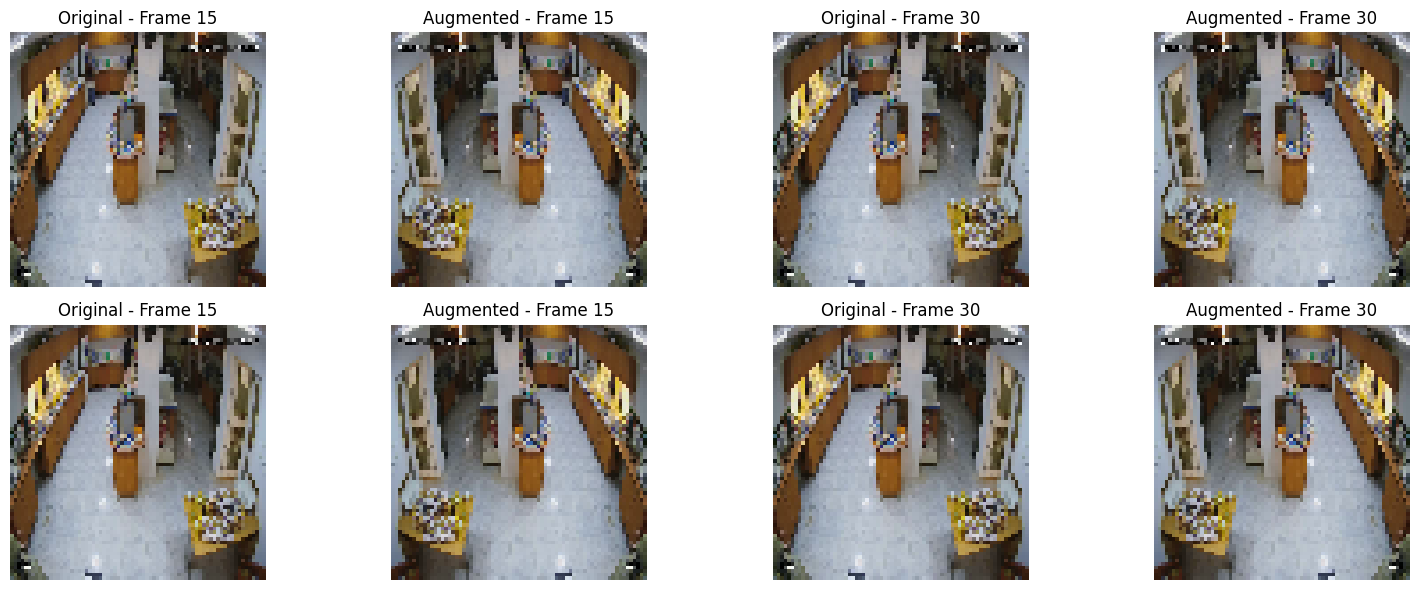


Augmentation: Brightness


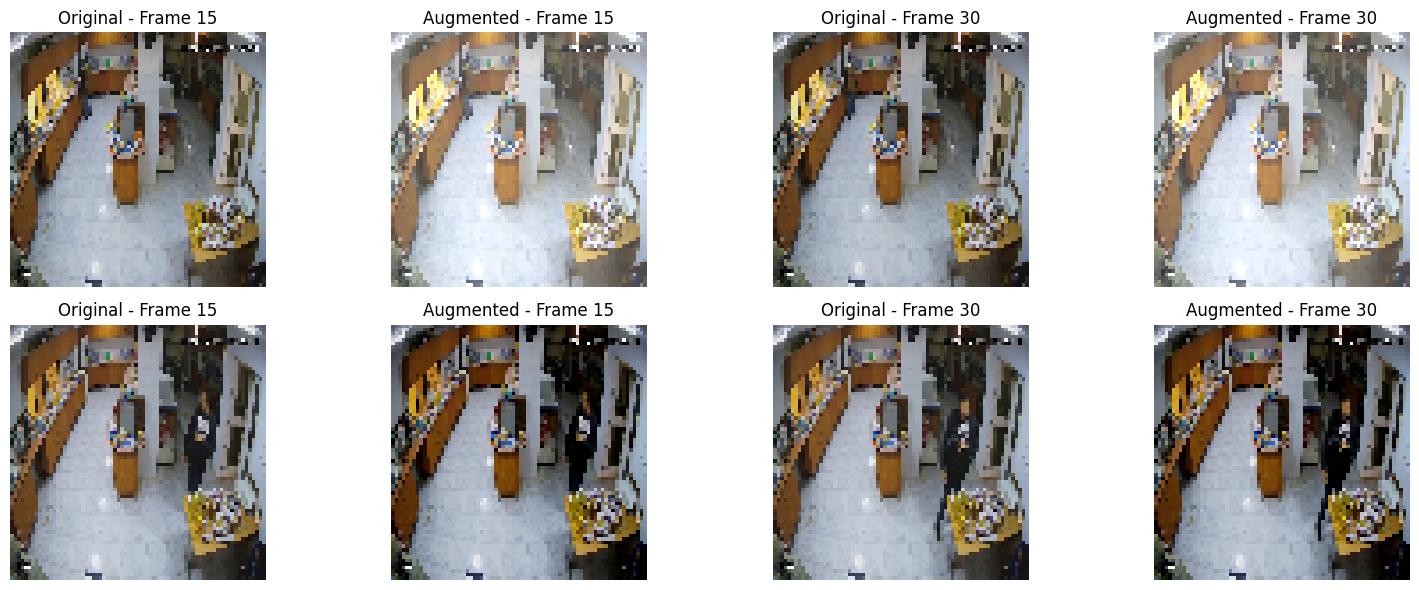


Augmentation: Zoom


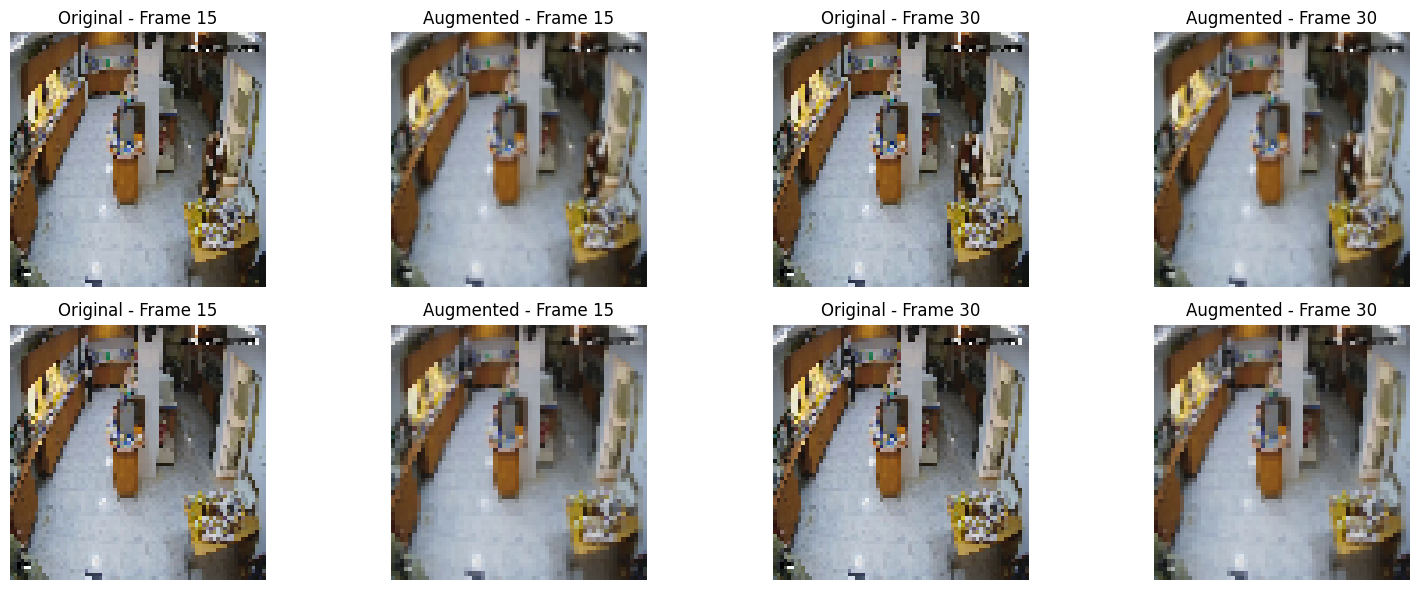

In [43]:
preview_individual_augmentations(videos_train, num_samples=2)

---

# PART 10: COMBINED AUGMENTATION WITH PROBABILITIES

### Apply Multiple Augmentations with Probabilities

In [44]:
# def apply_combined_augmentation(frames):
#     frames_uint8 = (frames * 255).astype(np.uint8)

#     # Spatial augmentations with probabilities
#     transform = A.ReplayCompose([
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, p=0.4),
#         # A.Rotate(limit=15, p=0.3)
#         # A.RandomScale(scale_limit=0.2, p=0.3),
#     ])

#     # Apply to all frames consistently
#     data = transform(image=frames_uint8[0])
#     augmented = []
#     for frame in frames_uint8:
#         aug_frame = A.ReplayCompose.replay(data['replay'], image=frame)
#         augmented.append(aug_frame['image'].astype(np.float32) / 255.0)

#     augmented = np.array(augmented)

#     # Temporal crop (manual, not in albumentations)
#     if np.random.random() < 0.3:
#         augmented = augment_temporal_crop(augmented)

#     return augmented

In [45]:
def apply_combined_augmentation(frames, augment=True):
    """
    Apply consistent spatial augmentation across all frames of a video.
    Keeps temporal integrity intact.
    """
    if not augment:
        return frames

    input_shape = frames.shape
    frames_uint8 = (frames * 255).astype(np.uint8)

    transform = get_augmentation_pipeline()

    # Apply once to the first frame to generate a replay record
    data = transform(image=frames_uint8[0])
    replay_params = data['replay']

    # Apply the same replay transform to all frames
    augmented = [
        A.ReplayCompose.replay(replay_params, image=frame)['image'].astype(np.float32) / 255.0
        for frame in frames_uint8
    ]

    augmented = np.array(augmented)

    # Guarantee consistent shape
    if augmented.shape != input_shape:
        print(f"⚠️ Shape mismatch in augmentation! Input: {input_shape}, Output: {augmented.shape}")
        augmented = np.resize(augmented, input_shape)

    return augmented

**Corrected** `apply_combined_augmentation()`

The original version replays the same augmentation on every single frame, which often results in flat, identical sequences.

The new version applies **one consistent transform** across all frames with a single replay instance — as intended.

✅ **What’s fixed/improved**:

* Only one replay is generated per video → consistent transform.

* All frames share the same affine and brightness adjustments (preserves temporal consistency).

* Outputs always maintain `(num_frames, H, W, C)`.

### Visualizing the Multiple Augmentations

In [46]:
# def visualize_combined_augmentation(X_train, num_samples=5):
#     """Visualize combined augmentation"""
#     print("\n" + "="*60)
#     print("Combined Augmentation Visualization")
#     print("="*60 + "\n")

#     fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))

#     for i in range(num_samples):
#         idx = np.random.randint(0, len(X_train))
#         original = X_train[idx]
#         augmented = apply_combined_augmentation(original.copy())

#         frame_idx1 = NUM_FRAMES // 3
#         frame_idx2 = 2 * NUM_FRAMES // 3

#         if num_samples == 1:
#             axes = axes.reshape(1, -1)

#         axes[i, 0].imshow(original[frame_idx1])
#         axes[i, 0].set_title(f'Before - Frame {frame_idx1}')
#         axes[i, 0].axis('off')

#         axes[i, 1].imshow(augmented[frame_idx1])
#         axes[i, 1].set_title(f'After - Frame {frame_idx1}')
#         axes[i, 1].axis('off')

#         axes[i, 2].imshow(original[frame_idx2])
#         axes[i, 2].set_title(f'Before - Frame {frame_idx2}')
#         axes[i, 2].axis('off')

#         axes[i, 3].imshow(augmented[frame_idx2])
#         axes[i, 3].set_title(f'After - Frame {frame_idx2}')
#         axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

In [47]:
# visualize_combined_augmentation(videos_train, num_samples=6)

---

# PART 11: APPLY AUGMENTATION TO TRAINING DATA

### Fixed Function for the dimensions problem

In [48]:
def pad_videos_to_same_length(videos, target_frames=NUM_FRAMES):
    """
    Pad or truncate all videos to the same number of frames
    """
    padded_videos = []
    for video in videos:
        num_frames = len(video)
        if num_frames < target_frames:
            # Pad by repeating last frame
            padding_needed = target_frames - num_frames
            padding = np.repeat(video[-1:], padding_needed, axis=0)
            padded_video = np.concatenate([video, padding], axis=0)
        elif num_frames > target_frames:
            # Truncate by sampling evenly
            indices = np.linspace(0, num_frames - 1, target_frames, dtype=int)
            padded_video = video[indices]
        else:
            padded_video = video

        padded_videos.append(padded_video)

    return np.array(padded_videos)

### Fixed augment function

In [49]:
def augment_dataset(X, y, augmentation_factor=1):
    """
    Apply augmentation to increase dataset size
    augmentation_factor: how many augmented versions to create per sample
    """
    X_augmented = []
    y_augmented = []

    print("Applying augmentation to training data...")

    # Keep original data
    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])

    # Add augmented versions
    for _ in range(augmentation_factor):
        for i in tqdm(range(len(X))):
            augmented_frames = apply_combined_augmentation(X[i].copy())
            X_augmented.append(augmented_frames)
            y_augmented.append(y[i])

    # DON'T convert to numpy array yet - keep as list
    return X_augmented, y_augmented  # Return lists, not np.array()

In [50]:
# Apply augmentation to training data (create 1 augmented version per sample)
videos_train_aug, labels_train_aug = augment_dataset(videos_train, labels_train, augmentation_factor=1)

print(f"\nOriginal training set size: {len(videos_train)}")
print(f"Augmented training set size: {len(videos_train_aug)}")

Applying augmentation to training data...


100%|██████████| 534/534 [00:27<00:00, 19.43it/s]


Original training set size: 534
Augmented training set size: 1068


---

# PART 12: BUILD PRETRAINED CNN+CONVLSTM MODEL

### Building the Model

In [51]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_cnn_convlstm_model(input_shape, num_classes, trainable_layers=30):
    """
    Pretrained MobileNetV2 + ConvLSTM model for video classification
    Uses pretrained CNN for spatial feature extraction + ConvLSTM for temporal modeling
    """

    # Define CNN base (pretrained)
    cnn_base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(input_shape[1], input_shape[2], input_shape[3])
    )

    # Freeze most layers, fine-tune last few
    for layer in cnn_base.layers[:-trainable_layers]:
        layer.trainable = False

    cnn_base.trainable = True

    # Define per-frame feature extractor
    cnn_out = keras.Sequential([
        cnn_base,
        layers.GlobalAveragePooling2D()
    ], name="cnn_feature_extractor")

    # Apply CNN over time dimension (frames)
    inputs = keras.Input(shape=input_shape)

    # Extract features per frame
    x = layers.TimeDistributed(cnn_out)(inputs)

    # Reshape for ConvLSTM: need (time, height, width, channels)
    # But our CNN outputs 1D features; to apply ConvLSTM, project to spatial grid
    x = layers.TimeDistributed(layers.Reshape((8, 8, -1)))(x)

    # Temporal modeling with ConvLSTM2D
    x = layers.ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        activation='tanh',
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Dense classification head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="MobileNetV2_ConvLSTM")

    return model

**Added Regularization** for some layers except for CNN, since it has `Batch Normalization` and `dropout`

For `LSTM RNN`, the reason is **Temporal modeling can easily memorize frame order.**

For `Fully connected`, the reason is **Fully connected — tends to overfit most**

Dense(64) is a small layer so regularization is optional

In [52]:
input_shape = (NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

nn_model = build_cnn_convlstm_model(input_shape, NUM_CLASSES, trainable_layers=30)

I0000 00:00:1762017538.832648      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [53]:
print("Model built successfully!")
nn_model.summary()

Model built successfully!


Model: "MobileNetV2_ConvLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 45, 72, 72, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 45, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 45, 8, 8, 20)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 8, 8, 128)      │       682,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,073,090 (19.35 MB)

 Trainable params: 4,340,482 (16.56 MB)

 Non-trainable params: 732,608 (2.79 MB)

### Compile the Model

In [54]:
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**for sigmoid (binary classification)**

In [55]:
# @title
# nn_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

---

# PART 13: SETUP CALLBACKS AND TRAIN MODEL

In [56]:
# Create directory for saving models
os.makedirs('/kaggle/working/models', exist_ok=True)

In [57]:
# Define callbacks
checkpoint = ModelCheckpoint(
    '/kaggle/working/models/best_model.keras',
    monitor='val_loss',   # monitor='val_accuracy'
    save_best_only=True,
    mode='min',               # mode='max'
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,  # was  0.5
    patience=6,   # was 5
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

In [58]:
callbacks = [checkpoint, reduce_lr] # , early_stopping

For **softmax only**

Comment for **sigmoid**

In [59]:
## Convert labels to categorical for training (softmax, not needed for sigmoid, I used sparse categorical crossentropy, so I don't need to OHE the label)
# y_train_cat = to_categorical(labels_train_aug, num_classes=NUM_CLASSES)

In [60]:
# Train the model
# print("\nStarting training...")
# nn_model_fit = nn_model.fit(
#     videos_train_aug, labels_train_aug,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_split=0.2,
#     callbacks=callbacks,
#     shuffle=True,
#     verbose=1
# )

# print("\nTraining completed!")

### Conversion to numpy before training

In [61]:
# Pad videos to same length before training (a precaution, but not needed)
# print("Padding videos to uniform length...")
# videos_train_aug_padded = pad_videos_to_same_length(videos_train_aug, target_frames=NUM_FRAMES)
# labels_train_aug_array = np.array(labels_train_aug)

# print(f"Padded training shape: {videos_train_aug_padded.shape}")

In [62]:
# Train the model
print("\nStarting training...")

nn_model_fit = nn_model.fit(
    np.array(videos_train_aug), np.array(labels_train_aug),  # Convert to numpy here during fit
    validation_data= (np.array(videos_val), np.array(labels_val) ),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # validation_split=0.2, # to split the train data after augmentation here (worse for memory, faster code)
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training...
Epoch 1/80


I0000 00:00:1762017814.975947   10006 service.cc:148] XLA service 0x34876790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762017814.976643   10006 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762017851.985082   10006 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762017875.470604   10006 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762017875.652512   10006 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762017875.858974   10006 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762017876.040798  

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5232 - loss: 1.3151
Epoch 1: val_loss improved from inf to 0.68237, saving model to /kaggle/working/models/best_model.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 588s 492ms/step - accuracy: 0.5233 - loss: 1.3149 - val_accuracy: 0.6957 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 2/80
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5953 - loss: 1.1087
Epoch 2: val_loss improved from 0.68237 to 0.58075, saving model to /kaggle/working/models/best_model.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.5953 - loss: 1.1087 - val_accuracy: 0.7739 - val_loss: 0.5807 - learning_rate: 1.0000e-04
Epoch 3/80
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5791 - loss: 1.0405
Epoch 3: val_loss improved from 0.58075 to 0.50838, saving model to /kaggle/working/models/best_model.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.5790 - loss: 1.0406 - val_accuracy: 0.8087 - val_loss: 0.5084 - learning

---

# PART 14: PLOT TRAINING HISTORY

In [63]:
def plot_training_history(model):
    """
    Plot accuracy and loss curves
    """
    # Plot Accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Training Accuracy', linewidth=2, color="blue")
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color="green")
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='Training Loss', linewidth=2, color="red")
    plt.plot(model.history['val_loss'], label='Validation Loss', linewidth=2, color="orange")
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

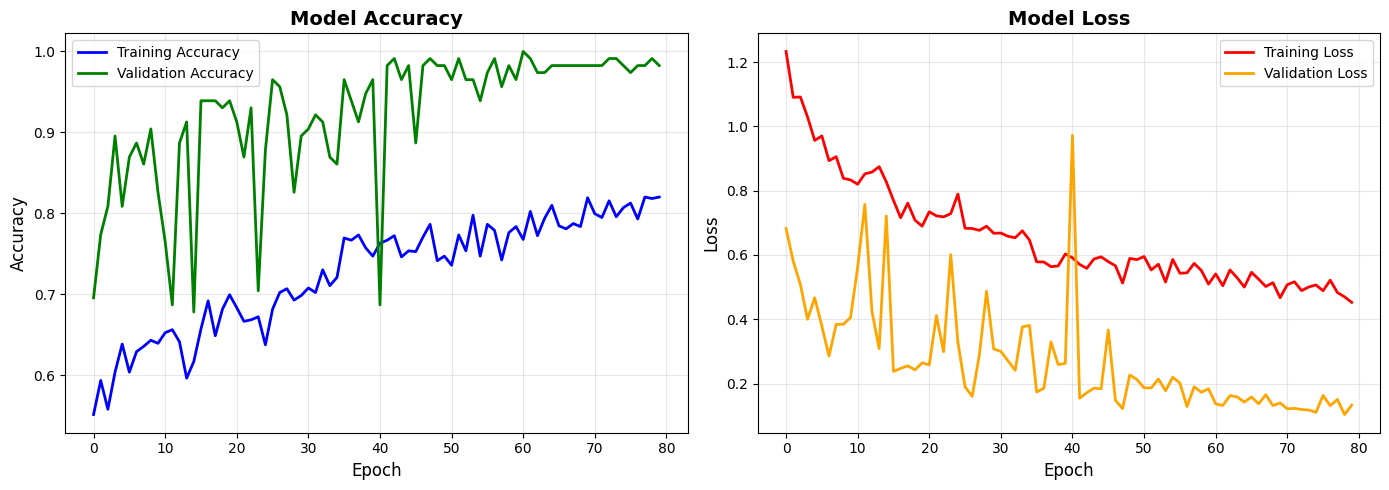

In [64]:
## Plot training history
plot_training_history(nn_model_fit)

---

# PART 15: EVALUATE MODEL ON TEST SET

In [65]:
# Load best model
nn_model.load_weights('/kaggle/working/models/best_model.keras')

---

## For loading the best weights by the model (don't run the fitting, the build part or callbacks(if you won't train it again) )

#### ***You should always do this loading after plotting the history (accuracy and loss curves) and before evaluations to test the best model weights you got not the latest ones.

In [66]:
# Load your trained model
# nn_model = tf.keras.models.load_model("/kaggle/working/models/best_model.keras")

# print("✅ Model loaded successfully!")

The model file `best_model.keras` already contains **weights**, **architecture**, and **optimizer state** — so no need to rebuild the architecture manually.

👉 **Do I need to compile the saved weights?**

**Short answer**:

❌ No, you do not need to compile the model just to use it for inference (prediction).

✅ You only need to compile it again if you plan to continue training or evaluate it with metrics that require compilation.

---

In [67]:
# Make predictions on test set
print("Making predictions on test set...")
labels_pred_probs = nn_model.predict(videos_test, batch_size=BATCH_SIZE)

## Softmax
labels_pred = np.argmax(labels_pred_probs, axis=1)

## Sigmoid
# labels_pred = (labels_pred_probs > 0.5).astype(int).flatten()  # Change from argmax

print("Predictions completed!")

Making predictions on test set...
39/39 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step
Predictions completed!


---

# PART 16: CLASSIFICATION REPORT AND METRICS

In [68]:
# Calculate metrics
accuracy = accuracy_score(labels_test, labels_pred)
precision = precision_score(labels_test, labels_pred, average='weighted')
recall = recall_score(labels_test, labels_pred, average='weighted')
f1 = f1_score(labels_test, labels_pred, average='weighted')

In [69]:
print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


MODEL EVALUATION METRICS

Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


In [70]:
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(labels_test, labels_pred, target_names=CLASS_NAMES))


CLASSIFICATION REPORT
                precision    recall  f1-score   support

non_shoplifter       1.00      1.00      1.00        66
    shoplifter       1.00      1.00      1.00        49

      accuracy                           1.00       115
     macro avg       1.00      1.00      1.00       115
  weighted avg       1.00      1.00      1.00       115



---

# PART 17: CONFUSION MATRIX VISUALIZATION

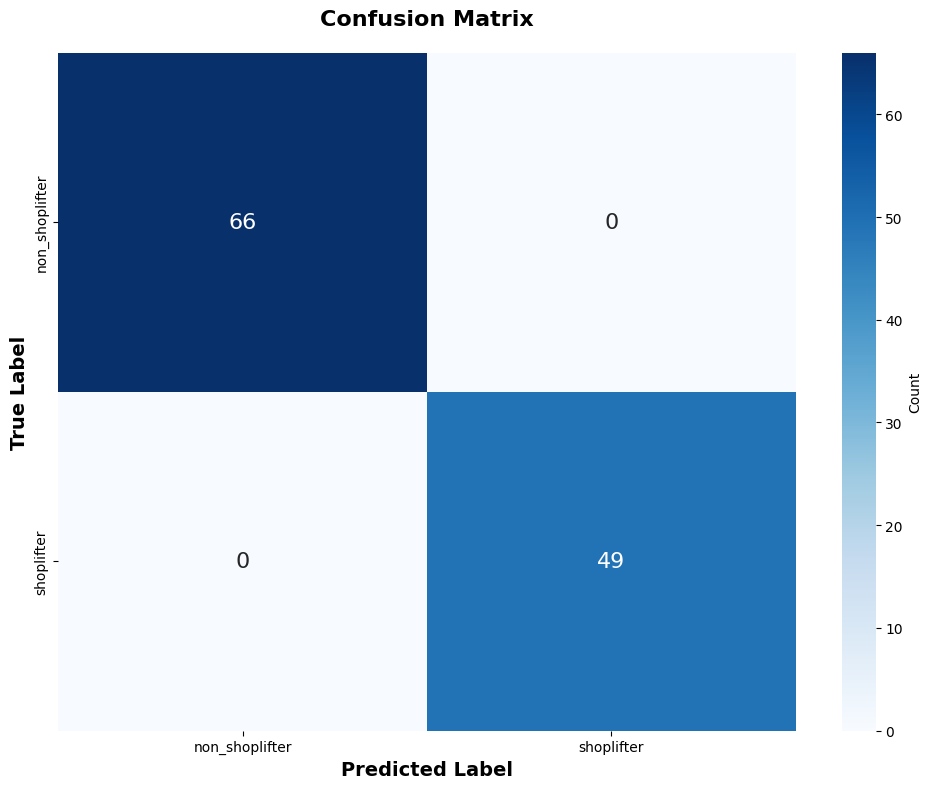

In [71]:
## Compute confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

## Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [72]:
# Print confusion matrix values
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")


Confusion Matrix:
[[66  0]
 [ 0 49]]

True Negatives:  66
False Positives: 0
False Negatives: 0
True Positives:  49


---

# Part 18: ROC Curve Evaluation

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(nn_model, videos_test, labels_test, BATCH_SIZE):
    """
    Plot ROC curve and compute AUC for binary classification.
    Assumes model outputs softmax probabilities with shape (N, 2).
    """
    print("\nComputing ROC curve and AUC score...")

    # Predict probabilities on test set
    labels_pred_probs = nn_model.predict(videos_test, batch_size=BATCH_SIZE)

    # Extract probability of the positive class (index 1)
    y_pred_proba = labels_pred_probs[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred_proba)
    auc_score = roc_auc_score(labels_test, y_pred_proba)

    # Print AUC
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Computing ROC curve and AUC score...
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
AUC Score: 1.0000


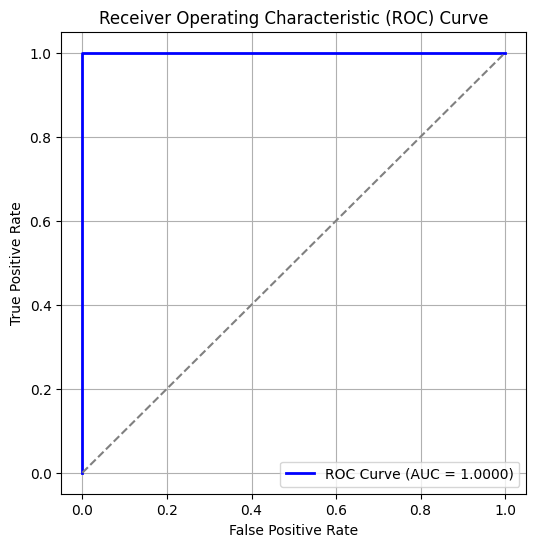

In [74]:
# Plot ROC curve + AUC
plot_roc_auc(nn_model, videos_test, labels_test, BATCH_SIZE)


`ROC — Receiver Operating Characteristic`

* It’s a curve that shows how well your model can distinguish between classes.

* The ROC curve plots:

    * `True Positive Rate (TPR)` on the **y-axis** (also called Recall or Sensitivity)

    * `False Positive Rate (FPR)` on the **x-axis**


* Each point on the ROC curve corresponds to a different classification threshold (from 0 → 1).

In simpler terms:

ROC shows how your model’s performance changes as you vary the threshold for deciding what counts as “positive”.

`AUC — Area Under the Curve` (of the ROC curve)

* It’s a single number that summarizes the ROC curve.

* Ranges from 0 to 1:

    * `1.0` → `Perfect classifier`

    * `0.5` → `Random guessing`

    * `<0.5` → `Worse than random` (model is confused or flipped)

👉 In short:

AUC tells you how well the model ranks positive examples higher than negative ones.

* **ROC curve** = visual performance at all thresholds

* **AUC** = numeric summary of how good that curve is

---

# PART 19: SAMPLE PREDICTIONS VISUALIZATION

In [75]:
def visualize_predictions(X_test, y_test, y_pred, num_samples=6):
    """
    Visualize sample predictions with ground truth and predicted labels
    """
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        # Get middle frame from video
        frame = X_test[idx][NUM_FRAMES // 2]
        true_label = CLASS_NAMES[y_test[idx]]
        pred_label = CLASS_NAMES[y_pred[idx]]

        # Determine if prediction is correct
        color = 'green' if y_test[idx] == y_pred[idx] else 'red'

        axes[i].imshow(frame)
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label}',
                         color=color, fontweight='bold', fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


SAMPLE PREDICTIONS


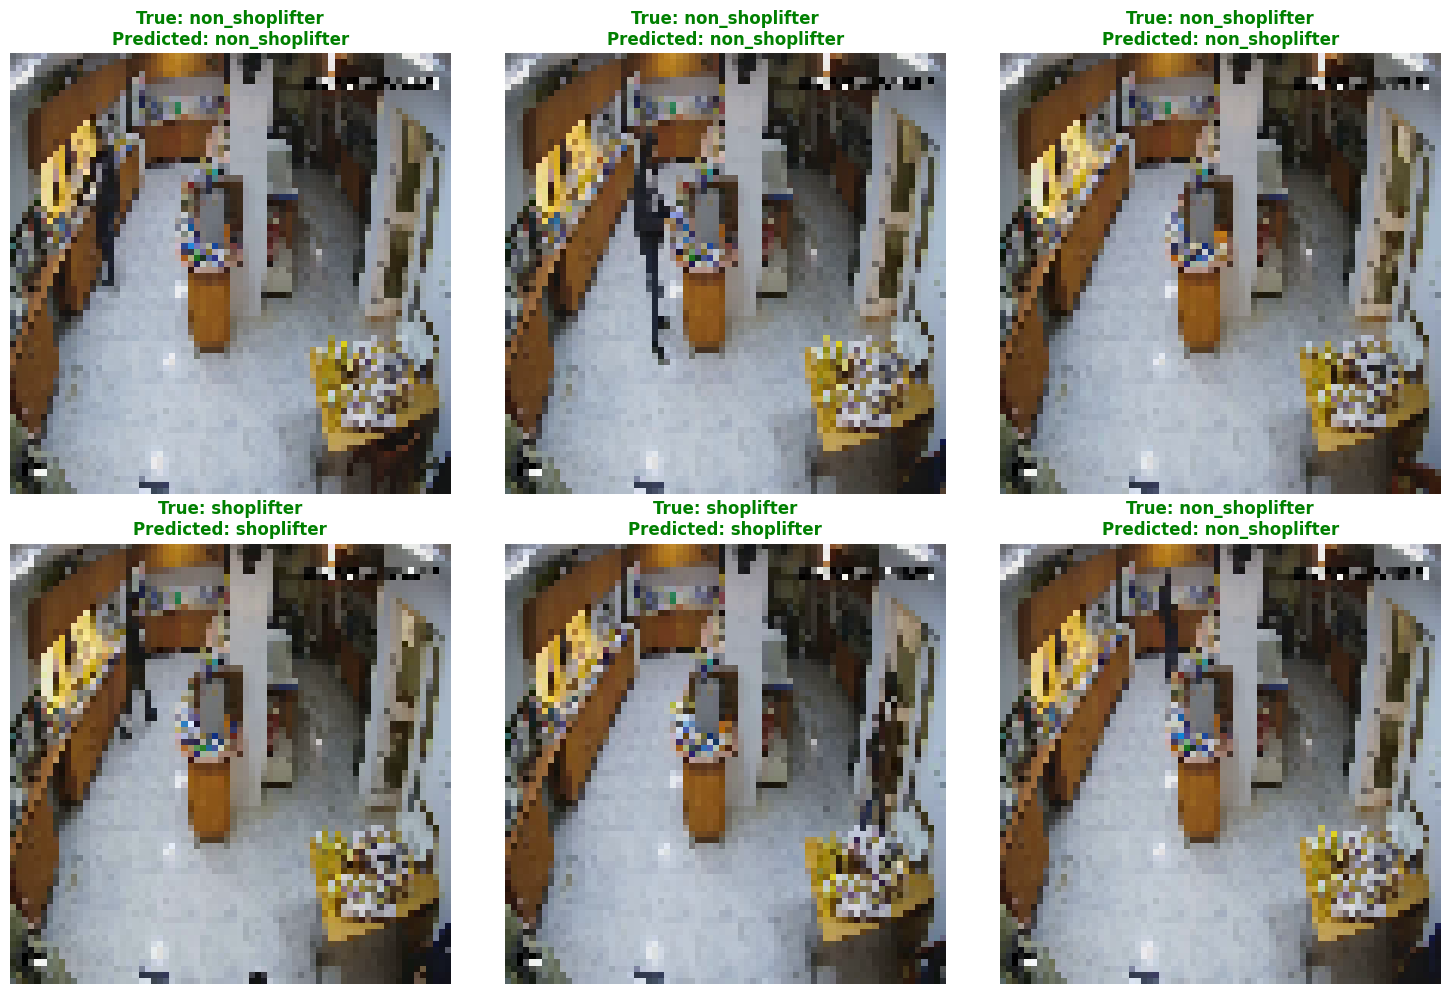

In [76]:
# Visualize sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
visualize_predictions(videos_test, labels_test, labels_pred, num_samples=6)

---

# Part 20: Function to predict a random video

In [79]:
# import cv2
# from IPython.display import HTML
# from base64 import b64encode

# def play_video_in_notebook(video_frames, fps=10):
#     """
#     Utility to play numpy video (frames) directly in notebook as mp4.
#     """
#     height, width, _ = video_frames[0].shape
#     out_path = "/tmp/temp_video.mp4"
#     out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

#     for frame in video_frames:
#         # Convert RGB -> BGR for OpenCV before writing
#         out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#     out.release()

#     # Read and encode the video for notebook display
#     mp4 = open(out_path, "rb").read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#     return HTML(f"""
#     <video width=400 controls>
#         <source src="{data_url}" type="video/mp4">
#     </video>
#     """)

### Fixed Function

In [80]:
import cv2
import tempfile
import IPython.display as display
from IPython.display import HTML

def play_video_in_notebook(video_frames, fps=20):
    """Properly encode and play a video inline in Kaggle/Jupyter."""
    # Convert frames to uint8 if not already
    video_frames = [(frame * 255).astype('uint8') if frame.dtype != 'uint8' else frame for frame in video_frames]

    # Save video to a temporary file
    tmp_file = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False)
    height, width = video_frames[0].shape[:2]
    out = cv2.VideoWriter(
        tmp_file.name,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (width, height)
    )

    for frame in video_frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    out.release()

    # Encode properly for inline playback
    video_html = f"""
    <video width="640" height="480" controls autoplay loop>
      <source src="data:video/mp4;base64,{base64.b64encode(open(tmp_file.name,"rb").read()).decode()}" type="video/mp4">
    </video>
    """
    return HTML(video_html)

In [81]:
import cv2
import numpy as np
import os

def save_single_test_video(model, X_test, y_test, class_names,
                           video_index=None, fps=15, save_dir="./predicted_videos"):
    """
    Predict a single test video and save it (no overlays).
    """
    os.makedirs(save_dir, exist_ok=True)

    if video_index is None:
        video_index = np.random.randint(0, len(X_test))

    video = X_test[video_index]
    true_label = class_names[y_test[video_index]]

    # Predict class
    preds = model.predict(np.expand_dims(video, axis=0))
    pred_class = np.argmax(preds, axis=1)[0]
    pred_label = class_names[pred_class]

    # Convert to displayable format (uint8)
    display_video = [np.uint8(frame * 255) for frame in video]

    # Save
    h, w, _ = display_video[0].shape
    save_path = f"{save_dir}/video_pred_{pred_label}_true_{true_label}.mp4"
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for frame in display_video:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    out.release()

    print(f"✅ Saved: {save_path}")
    print(f"Prediction: {pred_label} | True Label: {true_label}")

    return save_path

In [100]:
# For one random test video
save_single_test_video(nn_model, videos_test, labels_test, CLASS_NAMES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
✅ Saved: ./predicted_videos/video_pred_non_shoplifter_true_non_shoplifter.mp4
Prediction: non_shoplifter | True Label: non_shoplifter


'./predicted_videos/video_pred_non_shoplifter_true_non_shoplifter.mp4'

---

# Part 21: Predicting the Output of a video from the dataset directly for better visualization

In [83]:
import os
import shutil

folder_path = "/kaggle/working/predicted_videos"

# Check if the folder exists
if os.path.exists(folder_path):
    # Remove all files and subdirectories inside the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # delete file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # delete subdirectory
        except Exception as e:
            print(f"⚠️ Failed to delete {file_path}. Reason: {e}")
    print(f"✅ Cleared all contents inside: {folder_path}")
else:
    print(f"⚠️ Folder not found: {folder_path}")

✅ Cleared all contents inside: /kaggle/working/predicted_videos


**Notes:**

* Upscaling to `128×128` is for **visualization only** — no problem at all.

* It's still not working right from visual prospective.

* You can adjust `fps` if the video looks too fast or slow.

In [84]:
import cv2
import numpy as np
import tensorflow as tf
import os
import subprocess
from IPython.display import Video, display

def make_video_playable(input_path):
    filename = os.path.basename(input_path)
    name, ext = os.path.splitext(filename)
    output_path = f"/kaggle/working/{name}_streamable.mp4"
    command = [
        "ffmpeg", "-y", "-i", input_path,
        "-vcodec", "libx264", "-acodec", "aac",
        "-strict", "experimental", output_path
    ]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.returncode != 0:
        print("❌ FFmpeg failed:\n", result.stderr.decode())
    else:
        print(f"✅ Streamable video saved at: {output_path}")
    return output_path

In [85]:
def show_video_in_notebook(video_path, width=500):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")
    display(Video(video_path, embed=True, width=width))

In [107]:
def predict_video_from_dataset(model, video_path, class_names, train_target_size=(72,72), num_frames=40, display_size=(128,128)):
    """
    - Samples up to `num_frames` evenly spaced frames
    - Resizes frames to model's expected size (train_target_size)
    - Displays the original video resized for visibility (display_size)
    """
    print(f"🎥 Processing video: {video_path}")

    
    ## Step 1: Read and store all frames
    cap = cv2.VideoCapture(video_path)
    all_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # ⚠️ Convert to RGB to match training
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_model = cv2.resize(frame, train_target_size) / 255.0  # for model
        frame_display = cv2.resize(frame, display_size)   # for visualization
        all_frames.append((frame_model, frame_display)) # Total frames of the video
    cap.release()

    total_frames = len(all_frames)
    print(f"Total frames: {total_frames}")
    
    ## Step 2: Sample frames evenly
    # 🛠️ Sample exactly num_frames evenly
    if total_frames >= num_frames:
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    else:
        indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)

    model_frames = np.array([all_frames[i][0] for i in indices])
    display_frames = [all_frames[i][1] for i in range(total_frames)]

    # Expand dims for batch
    X = np.expand_dims(model_frames, axis=0)
    print(f"Model input shape: {X.shape}")

    ## Step 3: Predict
    y_pred = model.predict(X)
    pred_class = np.argmax(y_pred, axis=1)[0]
    pred_label = class_names[pred_class]
    confidence = np.max(y_pred)
    print(f"🧠 Predicted Class: {pred_label} (Confidence: {confidence:.2f})")

    ## Step 4: Create playable version (Optional)
    streamable_path = make_video_playable(video_path)
    show_video_in_notebook(streamable_path, width=500)

    return pred_label, confidence

**Two Fixes from the older code: (in version 3)**

**1. Added RGB color conversion**

`OpenCV` reads images in `BGR` order, while `TensorFlow / Keras models` (and the dataset preprocessing) use `RGB`.

**2. Ensured correct frame sampling and shape**

The model was trained on a fixed number of frames (NUM_FRAMES).
I already had sampling logic, but we double-checked it and confirmed it produces exactly that many frames, not more or fewer.

In [108]:
# Path to a test video
video_path = "/kaggle/input/shop-lifting-dataset/Shop DataSet/shop lifters/shop_lifter_0.mp4"

# Run prediction and show video
prediction_class, confidence = predict_video_from_dataset(
    nn_model,
    video_path,
    class_names=CLASS_NAMES,
    train_target_size=(72,72),  # model's input size
    num_frames=NUM_FRAMES,      # model's trained frame count
    display_size=(128,128)      # for clearer visualization
)

🎥 Processing video: /kaggle/input/shop-lifting-dataset/Shop DataSet/shop lifters/shop_lifter_0.mp4
Total frames: 322
Model input shape: (1, 45, 72, 72, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
🧠 Predicted Class: shoplifter (Confidence: 0.99)
✅ Streamable video saved at: /kaggle/working/shop_lifter_0_streamable.mp4


### *Note for the future to do better preprocessing*

#### The best way to handle the dataset correctly and make the model train right, is to manually crop all videos to 75 frames (the video with the least amount of frames is 75 so that all videos have equal frames), we are talking about exactly 3 seconds (preferrably less than 3 seconds to be sure eg. 2.x) or if NUM_FRAMES didn't work with 75 go for 60 or 50(worked in this code).

#### Also, make sure to crop (leave) [manually] the important part of the person going near the objects in both folders (non shoplifter, shoplifter)

---

---

## ** Functions to Play a Video in Kaggle in general

In [88]:
# import os
# import subprocess
# from IPython.display import Video, display

# def make_video_playable(input_path):
#     """
#     Convert video to a Kaggle-playable format (MP4 with H.264 codec)
#     and store it in /kaggle/working/, since /kaggle/input is read-only.
#     """
#     filename = os.path.basename(input_path)
#     name, ext = os.path.splitext(filename)
#     output_path = f"/kaggle/working/{name}_streamable.mp4"

#     # Convert video using ffmpeg
#     command = [
#         "ffmpeg", "-y", "-i", input_path,
#         "-vcodec", "libx264", "-acodec", "aac",
#         "-strict", "experimental", output_path
#     ]
#     result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#     if result.returncode != 0:
#         print("❌ FFmpeg failed:\n", result.stderr.decode())
#     else:
#         print(f"✅ Streamable video saved at: {output_path}")

#     return output_path

In [89]:
# def show_video_in_notebook(video_path, width=256):
#     """Show a playable video inline in Kaggle notebook."""
#     if not os.path.exists(video_path):
#         raise FileNotFoundError(f"Video not found: {video_path}")
#     display(Video(video_path, embed=True, width=width))

In [90]:
# input_path = "/kaggle/input/shop-lifting-dataset/Shop DataSet/non shop lifters/shop_lifter_n_104_1.mp4"

# streamable_path = make_video_playable(input_path)
# show_video_in_notebook(streamable_path, width=256)

✅ Streamable video saved at: /kaggle/working/shop_lifter_n_104_1_streamable.mp4


---

---

# Notebook Remarks and Notes

### Improvements from Version 3

Improved `apply_combined_augmentation()`

Improved `extract_frames_from_video()`

Added Regularization and modified the `build_cnn_rnn_model` to reduce **overfitting**.

Added `ROC` and `AUC` for **further evaluation**.

Added a function that loads a video, shows it, predicts the output of the video and overlays the prediction text on the video

---

### *Note for the future to do better preprocessing*

#### The best way to handle the dataset correctly and make the model train right, is to manually crop all videos to 75 frames (the video with the least amount of frames is 75 so that all videos have equal frames), we are talking about exactly 3 seconds (preferrably less than 3 seconds to be sure eg. 2.x) or if NUM_FRAMES didn't work with 75 go for 60 or 50(worked in this code).

#### Also, make sure to crop (leave) [manually] the important part of the person going near the objects in both folders (non shoplifter, shoplifter)

---

## Issues:

### ** In the new function that shows the video and gives the prediction of the model

When OpenCV tried to write your video frame (`out.write()`), the frame’s **data type** wasn’t `uint8 or `uint16`.

It’s most likely **float32** (from TensorFlow preprocessing or normalization).

So OpenCV can’t save or display float images.

**Error**:

"**error: (-215:Assertion failed) image.depth() == CV_8U || image.depth() == CV_16U**"

✅ **Fix**

We just need to convert **frames** to **uint8 before writing**:

```
frame_uint8 = np.clip(frame * 255, 0, 255).astype(np.uint8)
out.write(cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR))
```

💡 **Why This Happens?**

* During preprocessing, you probably normalized frames:

```
frame = frame / 255.0
```

    → This makes pixels floats between 0–1.

* `OpenCV` expects `8-bit integers` **(0–255)**.

So multiplying back by 255 and casting to `uint8` before saving solves it.

---

### Short Note about the pipeline (the videos are completely separated)

👉 The pipeline correctly keeps all frames of one video together in one NumPy array and stores each video as a separate element in a larger array.

#### step by step:

1. **`extract_frames_from_video(video_path, num_frames=NUM_FRAMES)`**
   
    * Opens one video file with `cv2.VideoCapture(video_path)`

    * Reads a set number of frames (`NUM_FRAMES = 50`)

    * Returns a single NumPy array of shape:
  
      > (50, 64, 64, 3)

      Each element is a frame.
  

✅ → This function handles one video at a time.
It does not mix frames between videos.


2. **`preprocess_video(video_path)`**

    * Calls `extract_frames_from_video(video_path)`

    * Normalizes the frames to `[0,1]`

    * Returns the same `(50, 64, 64, 3)` array for that one video
  
✅ → Still per-video, isolated.

3. **`load_video_dataset(non_shoplifters_path, shoplifters_path)`**

    * Each loop iteration processes one video, converts it to an array `(50, 64, 64, 3)`, and appends it as **one element in the list** `videos`.
  
    * ```
      videos = []
      labels = []
      ...
      for video_file in non_shoplifter_files:
          frames = preprocess_video(video_path)
          videos.append(frames)
          labels.append(0)
      ```
  
    * After both classes are processed:
  
      ```
      videos = np.array(videos)
      labels = np.array(labels)
      ```
  
    * So videos becomes a NumPy array of shape:
  
      ```
      (num_videos, 50, 64, 64, 3)
      ```

✅ → The **first dimension (num_videos)** clearly separates each clip.
Each index `videos[i]` = one full, normalized, 50-frame video.

4. **`train_test_split`**

    * Splits entire video samples (not individual frames)
    * Maintains labels accordingly.
   ```
   videos_train, videos_test, labels_train, labels_test = train_test_split(...)
   ```

✅ → No frame leakage, videos remain isolated between train/test.

```
def augment_dataset(X, y, augmentation_factor=1):
    for i in range(len(X)):
        X_augmented.append(X[i])          # original video
        augmented_frames = apply_combined_augmentation(X[i].copy())
        X_augmented.append(augmented_frames)
```

✅ → Augmentation is applied to a full video at once, not mixed with others.
So each output element in X_augmented is still one video.

---

✅ **Final confirmation**

After all preprocessing:

```
videos_train.shape
# → (num_train_videos, 50, 64, 64, 3)
```

✅ Meaning:

* Axis 0 = video index

* Axis 1 = time/frame index

* Axis 2–4 = spatial + color channels

So yes — **each video is perfectly separated from the others throughout the entire pipeline.**